In [4]:
import os
import pdb
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import pydicom
import dicom2nifti
import h5py

from src.dataset import get_chaos_volumes, extract_array_as_HU, apply_ct_abdomen_filter
from src.config import Directories

data_dir = Directories.CHAOS
registrations_dir = Directories.CHAOS_REGISTRATIONS

In [5]:
data_dir

'/project/6052161/mattlk/workplace/CompNet-Medical/data/chaos'

In [6]:
volume_filepaths = get_chaos_volumes(data_dir)
patient_ids = sorted(os.listdir('../data/chaos/Train_Sets/CT/'))

# Create Segmented Slices and Volumes

In [ ]:
volumes = []

for i, patient_id in enumerate(patient_ids):
    
    slice_filepaths = volume_filepaths[i]
    break
    
    for j, pair in enumerate(slice_filepaths):
        
        liver_fp, mask_fp = pair
        
        dicom = pydicom.dcmread(liver_fp)
#         image = extract_array_as_HU(dicom)
#         image = apply_ct_abdomen_filter(image)
        image = dicom.pixel_array
        
        mask = np.array(Image.open(mask_fp))
        image = image * mask
        
        elem = pydicom.dataelem.DataElement(0x7fe00010, 'OW', image.tobytes())
        dicom["PixelData"] = elem
        
        # Create directory for segmented slices for the given patient
        patient_dir = os.path.join('registrations_dir', 'slices', f'{patient_id}_test')
        if not os.path.exists(patient_dir): os.mkdir(patient_dir)
        
        pydicom.write_file(os.path.join(patient_dir, f'{j:03}.dcm'), dicom)
    
    # Create the volume from segmented slices
    output_filepath = os.path.join('chaos_slices', f'volume-{patient_id}.nii')
    dicom2nifti.dicom_series_to_nifti(patient_dir, output_filepath)
    break

# Test Opening the New Slices

In [141]:
dicom = pydicom.dcmread(liver_fp)
image = extract_array_as_HU(dicom)
image = apply_ct_abdomen_filter(image)
image

array([[ 215, -135, -135, ..., -135, -135, -135],
       [-135, -135, -135, ..., -135, -135, -135],
       [-135, -135, -135, ..., -135, -135, -135],
       ...,
       [ 156,    4, -135, ..., -135, -135, -135],
       [ 215,  215,  181, ..., -135, -135, -135],
       [ 157,  215,  215, ..., -135, -135, -135]], dtype=int16)

In [155]:
dicom.pixel_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint16)

In [84]:
b = slices[...,50].tobytes()
a = np.frombuffer(b, dtype=np.int16)
a = np.reshape(a, newshape=(512, 512))

(512, 512)

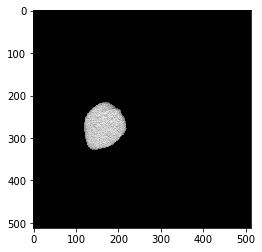

In [86]:
plt.imshow(a, cmap="gray")

In [135]:
dicom["PixelData"] = pydicom.dataelem.DataElement(0x7fe00010, 
                                                   'OW', image.tobytes())
dicom.pixel_array

array([[65401, 65401, 65401, ..., 65401, 65401, 65401],
       [65401, 65401, 65401, ..., 65401, 65401, 65401],
       [65401, 65401, 65401, ..., 65401, 65401, 65401],
       ...,
       [65401, 65401, 65401, ..., 65401, 65401, 65401],
       [65401, 65401, 65401, ..., 65401, 65401, 65401],
       [65401, 65401, 65401, ..., 65401, 65401, 65401]], dtype=uint16)

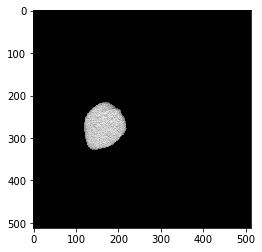

In [62]:
plt.imshow(slices[...,0], cmap="gray")

In [2]:
dicom2nifti.dicom_series_to_nifti('/home/mattlk/CompNet-Medical/data/chaos/Train_Sets/CT/24/DICOM_anon/',
                                  'volume-24.nii')

{'NII_FILE': 'volume-24.nii',
 'NII': <nibabel.nifti1.Nifti1Image at 0x2b005c2e0b38>,
 'MAX_SLICE_INCREMENT': 2.0000000000000004}

# Segment LiTS

In [2]:
data_dir = os.path.join(data_dir, 'media', 'nas', '01_Datasets', 'CT', 'LITS')
data_train_dir = os.path.join(data_dir, 'Training Set')
data_test_dir = os.path.join(data_dir, 'Testing Set')

volume_filepaths = [os.path.join(data_train_dir, name) for name in sorted(os.listdir(data_train_dir)) 
                    if 'volume' in name]
segmentation_filepaths = [os.path.join(data_train_dir, name) for name in sorted(os.listdir(data_train_dir)) 
                          if 'segmentation' in name]